In [82]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

dct_describe = {}
for index in ['SZZS','CYBZ','SZCZ']:
    
    if index == 'SZZS':
        rv_name = "szzsRV"
    else:
        rv_name = index + "RV"
        
    if index == 'CYBZ':
        file_time = "100601-190131"
    else:
        file_time = '080101-190131'
    
    # 对数收益率计算
    file_name_0 = 'C:/Users/jxjsj/Desktop/JupyterHome/Data/'+index+file_time+'.csv'
    
    SZZS = pd.read_csv(file_name_0,index_col=0)

    SZZS_p = pd.DataFrame(SZZS['close'],index=SZZS.index)

    SZZS_p['close-1'] = SZZS_p['close'].shift(1)

    SZZS_lnR = pd.DataFrame(np.log(SZZS_p['close'])-np.log(SZZS_p['close-1']),index=SZZS.index,columns=['lnR']).dropna(axis=0)

    SZZS_lnR_2 = pd.DataFrame(SZZS_lnR['lnR'].apply(lambda x:x*x))

    SZZS_lnR_2.columns = ['lnR_2']

    # pd.concat([SZZS_lnR,SZZS_lnR_2],axis=1).to_csv('C:/Users/jxjsj/Desktop/JupyterHome/Data/SZZS_r_new.csv')

    SZZS_temp = SZZS[['open','close','high','low']]
    SZZS_r = pd.concat([SZZS_lnR,SZZS_lnR_2,SZZS_temp,],axis=1,sort=True)

    # 上证指数已实现波动率计算
    file_name_1 = 'C:/Users/jxjsj/Desktop/JupyterHome/Data/'+index+'_five_min'+file_time+'.csv'
    
    df_fminSZZS = pd.read_csv(file_name_1,index_col=0,header=0)

    df_fminSZZS['time'] = list(df_fminSZZS.index)

    df_fminSZZS['date'] = list(df_fminSZZS['time'].apply(lambda x: str(x)[:10]))

    df_fminSZZS

    df_fminSZZS['close-1'] = df_fminSZZS['close'].shift(1)

    df_fminSZZS_lnR_temp = pd.DataFrame(np.log(df_fminSZZS['close'])-np.log(df_fminSZZS['close-1']),index=df_fminSZZS.index,columns=['lnR'])

    df_fminSZZS_lnR = pd.concat([df_fminSZZS_lnR_temp,pd.DataFrame(list(df_fminSZZS['date']),columns=['date'],index=df_fminSZZS.index)],axis=1).dropna(axis=0,how='any')

    df_fminSZZS_lnR['lnR^2'] = df_fminSZZS_lnR['lnR'].apply(lambda x: x*x)

    groupby_temp = df_fminSZZS_lnR['lnR^2'].groupby(df_fminSZZS_lnR['date'])

    groupby_df = pd.DataFrame(groupby_temp.sum())

    rvSZZS = pd.DataFrame(list(groupby_temp.sum()),columns=[rv_name],index=groupby_df.index)

    df_temp1 = pd.merge(SZZS_r,rvSZZS, left_index=True,right_index=True)

    # 月份哑变量设计
    time_temp = pd.date_range('1/1/2008','12/31/2019')

    time_df = pd.DataFrame(time_temp,columns=['date'])

    month_lst = list(time_df['date'].apply(lambda x: str(x)[5:7]))

    month_df = pd.DataFrame(month_lst,columns=['month'])

    month_temp = pd.get_dummies(month_df)

    time_month_temp = pd.concat([time_df,month_temp],axis=1)

    time_month_temp.columns = ['date','Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec']

    time_month = time_month_temp[['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec']]

    time_month.index=list(time_month_temp['date'])

    df_temp2 = pd.merge(df_temp1,time_month, left_index=True,right_index=True)

    # 星期哑变量设计
    time_temp = pd.date_range('1/1/2008','12/31/2019')

    time_df = pd.DataFrame(time_temp,columns=['date'])

    lst_week = []
    n=627
    while n>0:
        for i in [2,3,4,5,6,7,1]:
            lst_week.append(i)
        n-=1

    week_temp = pd.get_dummies(pd.DataFrame(lst_week[:4383],columns=['week'])['week'])

    time_week_temp = pd.concat([time_df,week_temp],axis=1)

    time_week_temp.columns = ['date','M','Tu','W','Th',"F","Sa",'Su']

    time_week = time_week_temp[['M','Tu','W','Th',"F","Sa",'Su']]

    time_week.index=list(time_week_temp['date'])

    df_temp3 = pd.merge(df_temp2,time_week, left_index=True,right_index=True)

    # 休市天数计算
    import datetime
    notrade = pd.DataFrame(list(SZZS.index),columns=['date'])

    notrade['date-1'] = notrade['date'].shift(1)

    notrade = notrade.dropna(axis=0,how='any')

    notrade_daycnt_temp = pd.DataFrame(notrade['date']+notrade['date-1'],columns=['daycnt'])

    notrade_daycnt_lst = list(
        notrade_daycnt_temp['daycnt'].apply(
        lambda x: (datetime.datetime.strptime(x[:10], "%Y-%m-%d")-datetime.datetime.strptime(x[10:20], "%Y-%m-%d")).days-1
                             ))

    notrade_daycnt = pd.DataFrame(notrade_daycnt_lst,columns=['ntd_cnt'])
    notrade_daycnt.index = list(notrade['date'])

    df_temp4 = pd.merge(df_temp3,notrade_daycnt, left_index=True,right_index=True)

    # 换手率交易量
    file_name_2 = 'C:/Users/jxjsj/Desktop/JupyterHome/Data/'+index+'_motion090101-190227.csv'
    
    SZZS_motion = pd.read_csv(file_name_2,index_col=0)

    SZZS_motion['volume-1'] = SZZS_motion['volume'].shift(1)
    SZZS_motion['volumeR'] = np.log(SZZS_motion['volume']) - np.log(SZZS_motion['volume-1'])

    SZZS_motion['money-1'] = SZZS_motion['money'].shift(1)
    SZZS_motion['moneyR'] = np.log(SZZS_motion['money']) - np.log(SZZS_motion['money-1'])

    SZZS_motion['turnoverR'] = SZZS_motion['turnover_ratio']/100

    SZZS_motion_temp = SZZS_motion[['volume','money','volumeR','moneyR','turnoverR','pe_average']]

    df_temp5 = pd.merge(df_temp4,SZZS_motion_temp,how='left' ,left_index=True,right_index=True)
    df_temp5 = df_temp5.fillna(0)

    # 前日新闻条数   
    SZZS_new = pd.read_csv('C:/Users/jxjsj/Desktop/JupyterHome/Data/news_cnt_090101-190201.csv',index_col=0)

    df_temp6 = pd.merge(df_temp5,SZZS_new,how='left' ,left_index=True,right_index=True)

    # 5日均收益率
    df_temp6['lnRroll5'] = df_temp6['lnR'].rolling(5).mean()

    # 20日均换手率
    df_temp6['turnoverRroll20'] = df_temp6['turnoverR'].rolling(20).mean()

    # 20日均收益率
    df_temp6['lnRroll20'] = df_temp6['lnR'].rolling(20).mean()

    # 20日标准差
    df_temp6['stdlnRroll20'] = df_temp6['lnR'].rolling(20).std()

    # 60日方差
    df_temp6['varlnRroll60'] = df_temp6['lnR'].rolling(60).var()
    
    # 60日标准差
    df_temp6['stdlnRroll60'] = df_temp6['lnR'].rolling(60).std()
    
    # 20日标准差 - 60日标准差
    df_temp6['stdlnRroll20_60'] = df_temp6['stdlnRroll20'] - df_temp6['stdlnRroll60']

    ######################################################################################
    # 60日均收益率
    df_temp6['lnRroll60'] = df_temp6['lnR'].rolling(60).mean()

    # 60日标准差
    df_temp6['stdlnRroll60'] = df_temp6['lnR'].rolling(60).std()

    # 60日夏普 无风险0.04
    df_temp6['sharpe60'] = (df_temp6['lnRroll60']*250 - 0.04) / (df_temp6['stdlnRroll60']*(250**0.5))

    # 60日夏普倒数
    df_temp6['sharpe60'] = df_temp6['sharpe60'].apply(lambda x: 1/x)
    ######################################################################################

    # 威廉变异离散量 (收盘价－开盘价)/(最高价－最低价)×成交量，再做加和，使用过去6个交易日的数据
    df_temp6['WVAD_temp'] = (df_temp6.close-df_temp6.open)/(df_temp6.high-df_temp6.low)*df_temp6.volume
    df_temp6['WVAD'] = df_temp6['WVAD_temp'].rolling(6).sum()

    # 60日负偏度
    df_temp6['skewlnR60'] = -df_temp6['lnR'].rolling(60).skew()

    # 60日峰度
    df_temp6['kurtlnR60'] = df_temp6['lnR'].rolling(60).kurt()

    df_temp6 = df_temp6.fillna(0)

    
    # 主成分分析    
    from sklearn.decomposition import PCA

    ###################### 短期风险因素 ######################

#     # 合成成分
#     risk_pd = pd.concat([df_temp6['skewlnR60'],df_temp6['sharpe60'],df_temp6['kurtlnR60'],df_temp6['varlnRroll60']],axis=1)

#     # 标准化 - 统一量级、分布 (不直接计算，取有用部分计算均值和方差)
#     if index == 'CYBZ':
#         start_index = 0
#     else:
#         start_index = 489
#     df_used = risk_pd.iloc[start_index:,:]
#     for i in risk_pd.columns:
#         risk_pd[i] = risk_pd[i].apply(lambda x: (x-df_used[i].mean())/df_used[i].std())

#     pca=PCA(n_components=1)
#     newData=pca.fit_transform(risk_pd)
#     print(index,'risk_pc1',pca.explained_variance_ratio_)

#     df_temp6['risk'] = newData

    df_temp6['risk'] = df_temp6['pe_average']
    
    df_temp6['risk'] = df_temp6['risk'].shift(10) - df_temp6['risk'] # 10日差分，动态化

    ###################### 投资者情绪因素 ########################

    # 合成成分
    emotion_pd = pd.concat([df_temp6['turnoverRroll20'],df_temp6['WVAD']],axis=1)
    
    if index == 'CYBZ':
        start_index = 0
    else:
        start_index = 489
    df_used = emotion_pd.iloc[start_index:,:]

    # 标准化 - 统一量级、分布
    for i in emotion_pd.columns:
        emotion_pd[i] = emotion_pd[i].apply(lambda x: (x-df_used[i].mean())/df_used[i].std())

    pca=PCA(n_components=1)
    newData=pca.fit_transform(emotion_pd)
    print(index,'emotion_pc1',
          '\nexplained_variance_ratio',pca.explained_variance_ratio_,
          '\nsingular_values',pca.singular_values_,
          '\nnoise_variance',pca.noise_variance_)

    df_temp6['emotion'] = newData

    ###################### 政策因素 ########################
    
#     df_temp6['news'] = df_temp6['content'].rolling(5).mean()

    mean = df_temp6['content'].mean()
    
    df_temp6['news'] = df_temp6['content'].apply(lambda x : np.log(x+mean))
    
#     df_temp6['news'] = df_temp6['content'].rolling(50).sum()
    
#     df_temp6['news'] = df_temp6['news'].shift(50) - df_temp6['news'] # 10日差分，动态化

#     df_temp6['news'] = df_temp6['content']
                           
    #####################################################################################################################
  
    df_temp6 = df_temp6.fillna(0)
    
    # 构造交互项                       
    var_lst = ['risk','emotion','news']
    col_lst = ['M', 'Tu', 'Th', 'F','Jan','Feb','May','Dec','ntd_cnt'] # 第一阶段检验出现日历效应的时段，可能会变
    for var in var_lst:
        for column in col_lst:
            column_name = var + '_' + column
            df_temp6[column_name] = df_temp6[var]*df_temp6[column]

    ################### 最终筛选 #################### - 留下收益率、RV、日历哑变量、交互项
    
    name_lst0 = list(df_temp4.columns)
    for i in ['open', 'close', 'high', 'low']:
        name_lst0.remove(i)
        
    name_lst1 = []
    for i in var_lst:
        for j in col_lst:
            name_lst1.append(i+'_'+j)
            
    name_lst = name_lst0 + name_lst1 + ['risk','emotion','news']
    
    df_temp7 = df_temp6[name_lst]
    
    ################################################# 其他功能性输出 #################################################
    
    # 描述性统计
    if index == 'CYBZ':
        start_index = 0
    else:
        start_index = 489
    df_used = df_temp6.iloc[start_index:,:]
    dct_describe[index] = df_temp6[['lnR',rv_name,'risk','emotion','news']].describe()
    
    # 计算相关系数
    df_corr = df_temp6[['risk','emotion','news','lnR']]
    print(df_corr.corr())
    
    # 平稳性检验
    for i in ['risk','emotion','news','lnR',rv_name]:
        print(i,'ADF',statsmodels.tsa.stattools.adfuller(df_temp6[i])[1])
    
    
    file_name_3 = 'C:/Users/jxjsj/Desktop/JupyterHome/Data/'+index+'_lnr_rv_w_m_ntd_'+file_time+'adj.csv'
    df_temp7.to_csv(file_name_3)
    print('- - - - - - - - - - -')

SZZS emotion_pc1 
explained_variance_ratio [0.74159929] 
singular_values [78.03400324] 
noise_variance 0.7869955667512918
             risk   emotion      news       lnR
risk     1.000000 -0.131872  0.061093 -0.197715
emotion -0.131872  1.000000  0.212469  0.085248
news     0.061093  0.212469  1.000000  0.035563
lnR     -0.197715  0.085248  0.035563  1.000000
risk ADF 2.3092498100969306e-13
emotion ADF 0.03012211713839295
news ADF 0.0025528015553531393
lnR ADF 7.942861047426434e-24
szzsRV ADF 1.401878310637747e-06
- - - - - - - - - - -
CYBZ emotion_pc1 
explained_variance_ratio [0.54774116] 
singular_values [48.04353508] 
noise_variance 0.9045176730629161
             risk   emotion      news       lnR
risk     1.000000 -0.410673 -0.058963 -0.285063
emotion -0.410673  1.000000  0.362717  0.216772
news    -0.058963  0.362717  1.000000  0.033657
lnR     -0.285063  0.216772  0.033657  1.000000
risk ADF 2.0289544100119362e-13
emotion ADF 0.0006368115815732795
news ADF 0.0027697183980851135

In [84]:
def dct_to_excel(outputpath,df_dict):
        outputfile = outputpath
        writer = pd.ExcelWriter(outputfile)
        for key, value in df_dict.items():
            value.to_excel(writer,key,index=True)
        writer.save()
dct_to_excel('C:/Users/jxjsj/Desktop/JupyterHome/paper_word/varDescribe.xlsx',dct_describe)

In [51]:
time_used = 'ntd_cnt'
for i in var_lst:
    name = i + '_' + time_used
    print(time_used,i,list(df_temp7.columns).index(name)+1)

ntd_cnt risk 32
ntd_cnt emotion 41
ntd_cnt news 50


In [54]:
list(df_temp7.columns).index('news')+1

53

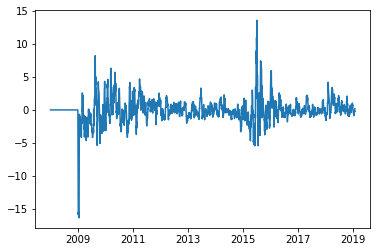

In [48]:
import matplotlib.pyplot as plt
plt.plot(df_temp6['risk'])
plt.show()

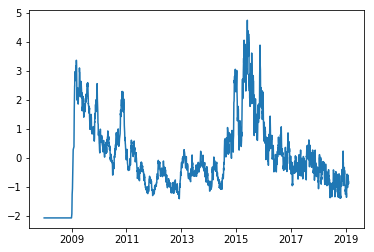

In [50]:
import matplotlib.pyplot as plt
plt.plot(df_temp6['emotion'])
plt.show()

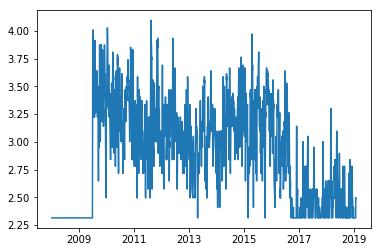

In [83]:
import matplotlib.pyplot as plt
plt.plot(df_temp6['news'])
plt.show()

In [37]:
df_temp6['news'].describe()

count    2697.000000
mean      -14.456909
std        47.798302
min      -153.484995
25%       -43.732526
50%         0.000000
75%        10.813698
max        94.346686
Name: news, dtype: float64